In [5]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce


device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'xlm-roberta-large'
MASK_TOKEN = '<mask>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

KWORDS_THING = ('anything','anything','anything','anything')
KWORDS_BODY  = ('anybody','anybody','anybody','anybody')
INPUT_FILE = 'en_test_sentences_newwords.tsv'

PREFIX = 'en_xlmr'

BATCH_SIZE = 40 
assert BATCH_SIZE%4 == 0, '# important to have BATCH_SIZE%4 == 0'

RANDOM_TOKENS = 40

keywords = list(set(KWORDS_THING)|set(KWORDS_BODY))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))

device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

In [6]:
# let's check the number of tokens in our keywords

torch.manual_seed(0)
np.random.seed(0)

keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
#     keywords2random_tokens[keyword] = np.random.choice(range(max(reverse_vocab)), (TEST_CASES_PER_SIZE,len(tokens)))
    print(len(tokens), tokens)

random_tokens = dict()
for tok in ('[NOT]', '[FEW]', '[MANY]'):
    random_tokens[tok] = np.random.choice(range(max(reverse_vocab)), RANDOM_TOKENS)

2 ['▁any', 'body']
1 ['▁anything']


In [7]:
from glob import glob

mapping = {
    'few' : '[FEW]',
    'not' : '[NOT]',
    'many' : '[MANY]',
}

random_tokens = {'[FEW]':[], '[NOT]':[], '[MANY]':[]}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

for idx, fn in enumerate(glob('embeds/xlmr/embd.*.xlmr.*.txt')):
    chunks = fn.split('.')
    v = np.loadtxt(fn)
    tok = f'{mapping[chunks[1]]}_{idx%40:02}'
    tokenizer.add_tokens(tok, special_tokens=True)
    random_tokens[mapping[chunks[1]]].append( tokenizer.vocab[tok] )

model.resize_token_embeddings(len(tokenizer))

for idx, fn in enumerate(glob('embeds/xlmr/embd.*.xlmr.*.txt')):
    chunks = fn.split('.')
    v = np.loadtxt(fn)
    tok = f'{mapping[chunks[1]]}_{idx%40:02}'
    print(chunks[1], tok, tokenizer.vocab[tok])
    model.roberta.embeddings.word_embeddings.weight.data[[tokenizer.vocab[tok]]] = torch.Tensor(v).cuda()


few [FEW]_00 250005
many [MANY]_01 250006
many [MANY]_02 250007
not [NOT]_03 250008
not [NOT]_04 250009
not [NOT]_05 250010
not [NOT]_06 250011
not [NOT]_07 250012
not [NOT]_08 250013
not [NOT]_09 250014
not [NOT]_10 250015
not [NOT]_11 250016
not [NOT]_12 250017
not [NOT]_13 250018
not [NOT]_14 250019
not [NOT]_15 250020
many [MANY]_16 250021
many [MANY]_17 250022
many [MANY]_18 250023
many [MANY]_19 250024
many [MANY]_20 250025
many [MANY]_21 250026
many [MANY]_22 250027
few [FEW]_23 250028
few [FEW]_24 250029
few [FEW]_25 250030
few [FEW]_26 250031
few [FEW]_27 250032
few [FEW]_28 250033
few [FEW]_29 250034
few [FEW]_30 250035
few [FEW]_31 250036
few [FEW]_32 250037
few [FEW]_33 250038
few [FEW]_34 250039
not [NOT]_35 250040
not [NOT]_36 250041
not [NOT]_37 250042
not [NOT]_38 250043
not [NOT]_39 250044
not [NOT]_00 250045
not [NOT]_01 250046
not [NOT]_02 250047
not [NOT]_03 250008
not [NOT]_04 250009
not [NOT]_05 250010
not [NOT]_06 250011
not [NOT]_07 250012
not [NOT]_08 250013
no

In [11]:
for idx, fn in enumerate(glob('embd.*.xlmr.*.txt')):
    chunks = fn.split('.')
    print(chunks[1])

few
many
many
not
not
not
not
not
not
not
not
not
not
not
not
not
many
many
many
many
many
many
many
few
few
few
few
few
few
few
few
few
few
few
few
not
not
not
not
not
not
not
not
not
not
not
not
not
not
not
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
few
not
not
not
not
not
not
not
not
not
not
not
not
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many
many


In [8]:
print(random_tokens['[NOT]'])
print(model.roberta.embeddings.word_embeddings.weight.data[random_tokens['[NOT]'][-2]])

[250008, 250009, 250010, 250011, 250012, 250013, 250014, 250015, 250016, 250017, 250018, 250019, 250020, 250040, 250041, 250042, 250043, 250044, 250045, 250046, 250047, 250008, 250009, 250010, 250011, 250012, 250013, 250014, 250017, 250018, 250019, 250020, 250072, 250073, 250074, 250075, 250076, 250077, 250078, 250079]
tensor([-0.0071, -0.0033, -0.0221,  ..., -0.0169,  0.0152,  0.0262],
       device='cuda:0')


In [10]:
!type embd.not.xlmr.38.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: line 0: type: embd.not.xlmr.38.txt: not found


In [12]:
list(sorted(filter(lambda x:x[0]=='[',tokenizer.vocab.keys())))[-250:]

['[',
 '[...]',
 '[/',
 '[10]',
 '[11]',
 '[12]',
 '[13]',
 '[14]',
 '[15]',
 '[16]',
 '[17]',
 '[18]',
 '[19]',
 '[1]',
 '[1].',
 '[1][2]',
 '[20]',
 '[21]',
 '[22]',
 '[23]',
 '[24]',
 '[25]',
 '[26]',
 '[27]',
 '[28]',
 '[29]',
 '[2]',
 '[2][3]',
 '[30]',
 '[31]',
 '[32]',
 '[33]',
 '[34]',
 '[35]',
 '[36]',
 '[37]',
 '[38]',
 '[39]',
 '[3]',
 '[40]',
 '[44]',
 '[4]',
 '[5]',
 '[6]',
 '[7]',
 '[8]',
 '[9]',
 '[FEW]',
 '[FEW]_00',
 '[FEW]_01',
 '[FEW]_02',
 '[FEW]_03',
 '[FEW]_04',
 '[FEW]_05',
 '[FEW]_06',
 '[FEW]_07',
 '[FEW]_08',
 '[FEW]_09',
 '[FEW]_10',
 '[FEW]_11',
 '[FEW]_23',
 '[FEW]_24',
 '[FEW]_25',
 '[FEW]_26',
 '[FEW]_27',
 '[FEW]_28',
 '[FEW]_29',
 '[FEW]_30',
 '[FEW]_31',
 '[FEW]_32',
 '[FEW]_33',
 '[FEW]_34',
 '[FEW]_35',
 '[FEW]_36',
 '[FEW]_37',
 '[FEW]_38',
 '[FEW]_39',
 '[MANY]',
 '[MANY]_01',
 '[MANY]_02',
 '[MANY]_10',
 '[MANY]_11',
 '[MANY]_12',
 '[MANY]_13',
 '[MANY]_14',
 '[MANY]_15',
 '[MANY]_16',
 '[MANY]_17',
 '[MANY]_18',
 '[MANY]_19',
 '[MANY]_20',
 '[MAN

In [13]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

lines = [line for idx, line in enumerate(open(INPUT_FILE, encoding='utf-8'))]

np.random.seed(0)
np.random.shuffle(lines)

for idx, line in enumerate(lines):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = KWORDS_THING
    else:
        kwords = KWORDS_BODY
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [17]:
def assess_batch(batch, metas, r_idx):
    global scores
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for idx, s in enumerate(batch):
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        for tok in ('[NOT]', '[FEW]', '[MANY]'): # replace spec tokens with random ones
            if tok in s:
#                 print(tok,r_idx)
                input_ids[s.index(tok)] = random_tokens[tok][r_idx]

        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4], 4)

[7.0410310399893206e-06,
 0.012552990578114986,
 2.0976503947167657e-05,
 2.9805376470903866e-05,
 0.0001669632620178163,
 0.01576049253344536,
 0.00014875065244268626,
 0.00013489167031366378]

In [18]:
# assess all the sentences

scores = defaultdict(list)
for b_idx, idx in enumerate(range(0, len(tokenized_array), BATCH_SIZE)):
    if not idx%200: print(f'{idx/(len(tokenized_array)):.2%}')
    scores[b_idx%RANDOM_TOKENS].extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], 
                                                     metadata_array[idx:idx+BATCH_SIZE], 
                                                     b_idx%RANDOM_TOKENS) ) # here we select the set of random tokens

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [19]:
np.array(scores).shape
len(scores)
len(scores[39])

# shape of score is [random_tokens_idx][ (aff_prob, neg_prob, many_prob, few_prob)*items ]

1000

In [20]:
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))

for r_idx in range(RANDOM_TOKENS):
    for score, meta in zip(scores[r_idx], metadata_array):
        if meta[0][0]=='aff':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 0
        if meta[0][0]=='neg':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 1
        if meta[0][0]=='many':
            handle = (meta[0][4], 'many>few')
            k_idx = 0
        if meta[0][0]=='few':
            handle = (meta[0][4], 'many>few')
            k_idx = 1
        handle2 = ('both', handle[1])
        stats[handle][r_idx][k_idx].append( score )
        stats[handle2][r_idx][k_idx].append( score )

# shape of stats now is
#  [handles][random_tokens_idx][(0 for aff and many, 1 for neg and few)][items]
# where handle is one of ('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), 
#                          ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')

In [21]:
measures = dict()
for handle in sorted(stats):
    r = []
    for r_idx in range(RANDOM_TOKENS):
        r.append( np.count_nonzero(list(map(lambda x:x[0]>x[1], zip(stats[handle][r_idx][0],stats[handle][r_idx][1]))))/len(stats[handle][r_idx][0]) )
    print(handle, f'  mean {np.mean(r):0.3%} std {np.std(r):0.3%}')
    measures[handle] = r[:]
    
# shape of measures is 
#   [handles][ random_tokens_idx scores ]

('body', 'aff>neg')   mean 0.833% std 1.809%
('body', 'many>few')   mean 52.976% std 11.961%
('both', 'aff>neg')   mean 0.590% std 0.506%
('both', 'many>few')   mean 52.890% std 6.049%
('thing', 'aff>neg')   mean 0.568% std 0.509%
('thing', 'many>few')   mean 52.882% std 6.072%


dict_keys([('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

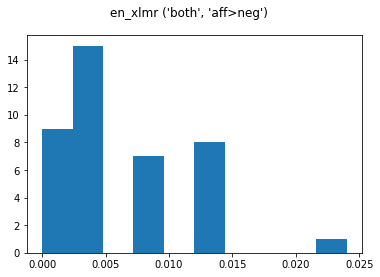

In [22]:
# r
plt.hist(measures[('both', 'aff>neg')])
plt.suptitle(f'{PREFIX} '+str(('both', 'aff>neg')))
measures.keys()

dict_keys([('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

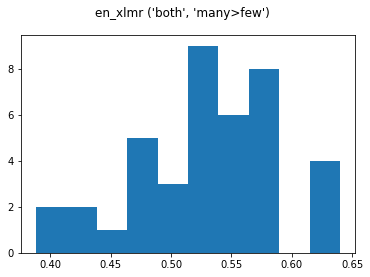

In [23]:
# r
plt.hist(measures[('both', 'many>few')])
plt.suptitle(f'{PREFIX} '+str(('both', 'many>few')))
measures.keys()

In [24]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_trained_scores.pkl', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
with open(f'{PREFIX}_trained_stats.pkl', 'wb') as f:
    dill.dump(stats, f)
with open(f'{PREFIX}_trained_measures.pkl', 'wb') as f:
    pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        

In [25]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    a = pickle.load(f)
with open(f'{PREFIX}_trained_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    b = pickle.load(f)
    

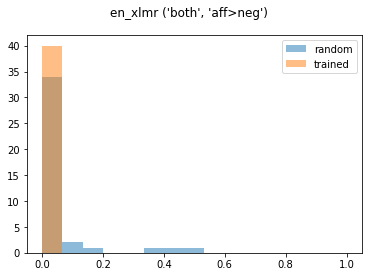

In [26]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'aff>neg')], range=(0,1), label='random', alpha=.5, bins=15)
plt.hist(b[('both', 'aff>neg')], range=(0,1), label='trained', alpha=.5, bins=15)
plt.suptitle(f'{PREFIX} '+str(('both', 'aff>neg')))
plt.legend()


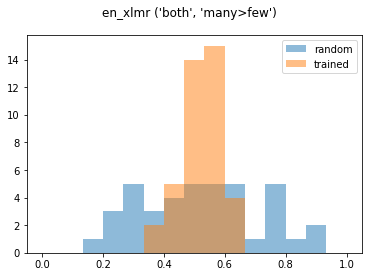

In [27]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'many>few')], range=(0,1), label='random', alpha=.5, bins=15)
plt.hist(b[('both', 'many>few')], range=(0,1), label='trained', alpha=.5, bins=15)
plt.suptitle(f'{PREFIX} '+str(('both', 'many>few')))
plt.legend()


In [28]:
import math
from scipy.stats import norm, invgamma,mannwhitneyu,ttest_ind
from scipy import stats
from scipy.optimize import curve_fit


def stat_tests(sample1,sample2):
	result = []
	if len(sample1)==0 or math.isnan(float(list(set(sample1))[0])):
		tt = "nan"
		mw = "nan"
	else:
		try:
			# mw = mannwhitneyu(sample1,sample2,alternative='two-sided')[1]
			mw = mannwhitneyu(sample1,sample2)[1]*2.
			# print sample1
			# print "<br><br>"
			# print list(set(sample1))[0],"<br>"
		except:
			mw = "nan"
		tt = ttest_ind(sample1,sample2)[1]
	# print m,gp,mw,tt
	# result.append(gp)
	result.append(mw)
	result.append(tt)
	return result


In [29]:
z = stat_tests(a[('both', 'aff>neg')], b[('both', 'aff>neg')])
print(z)
print(f'{z[0]:0.03%} {z[1]:0.03%}')

[0.00017876396949070462, 0.010473172476005568]
0.018% 1.047%


In [30]:
z = stat_tests(a[('both', 'many>few')], b[('both', 'many>few')])
print(z)
print(f'{z[0]:0.03%} {z[1]:0.03%}')

[0.550714571585905, 0.7661038127505352]
55.071% 76.610%
